In [15]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Dense, Flatten, Input, Dropout
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

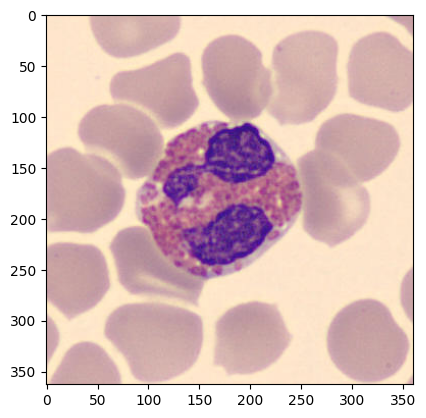

Found 17134 files belonging to 8 classes.
Using 13708 files for training.
Found 17134 files belonging to 8 classes.
Using 3426 files for validation.


In [17]:
# Einlesen eines Bildes
img = mpimg.imread('images/archive/bloodcells_dataset/eosinophil/EO_27.jpg')
imgplot = plt.imshow(img)
plt.show()

# Daten einlesen
image_size = (224, 224)
batch_size = 50
X_train = tf.keras.preprocessing.image_dataset_from_directory(
    "images/archive/bloodcells_dataset",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode="categorical"
)
X_test = tf.keras.preprocessing.image_dataset_from_directory(
    "images/archive/bloodcells_dataset",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode="categorical"
)

In [18]:
# Daten vorbereiten
train_ds = X_train.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = X_test.prefetch(buffer_size=tf.data.AUTOTUNE)

# Die Gewichte des VGG16 freezen
vgg16 = VGG16(include_top=False, input_shape=(224, 224, 3))
vgg16.trainable = False

# Transfer Learning Model aufbauen
model = Sequential()
model.add(Input(shape=(224, 224, 3)))
model.add(keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"))
model.add(keras.layers.experimental.preprocessing.RandomRotation(0.1))
model.add(keras.layers.experimental.preprocessing.Rescaling(1.0 / 255) )
model.add(vgg16)

# Eigener Decision Bereich
model.add(Flatten())
model.add(Dense(1024, activation="relu"))
#model.add(Dropout(0.3))  # Dropout für Regularisierung
model.add(Dense(512, activation="relu"))
#model.add(Dropout(0.3))
model.add(Dense(8, activation='softmax'))

# Modell kompilieren
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="categorical_crossentropy", metrics=["accuracy"])

# Zusammenfassung des Modells anzeigen
model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 224, 224, 3)       0         
 ation)                                                          
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1024)              25

In [19]:
# Frühes Stoppen bei schlechten Ergebnissen
callbacks = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_accuracy", min_delta=0.005)

# Modell trainieren
history1 = model.fit(train_ds.take(100), epochs=15, batch_size=50, validation_data=val_ds, callbacks=[callbacks])

history2 = model.fit(train_ds.take(50), epochs=30, batch_size=50, validation_data=val_ds, callbacks=[callbacks])


Epoch 1/15
100/100 [==============================] - 1365s 13s/step - loss: 1.9995 - accuracy: 0.6110 - val_loss: 0.5237 - val_accuracy: 0.8415
Epoch 2/15
100/100 [==============================] - 44s 435ms/step - loss: 0.4000 - accuracy: 0.8646 - val_loss: 0.3684 - val_accuracy: 0.8806
Epoch 3/15
100/100 [==============================] - 44s 431ms/step - loss: 0.3447 - accuracy: 0.8838 - val_loss: 0.4051 - val_accuracy: 0.8491
Epoch 4/15
100/100 [==============================] - 46s 458ms/step - loss: 0.2868 - accuracy: 0.9030 - val_loss: 0.4350 - val_accuracy: 0.8561
Epoch 5/15
100/100 [==============================] - 44s 429ms/step - loss: 0.2409 - accuracy: 0.9190 - val_loss: 0.4747 - val_accuracy: 0.8406
Epoch 6/15
100/100 [==============================] - 46s 459ms/step - loss: 0.2753 - accuracy: 0.9048 - val_loss: 0.3035 - val_accuracy: 0.8975
Epoch 7/15
100/100 [==============================] - 47s 459ms/step - loss: 0.2394 - accuracy: 0.9134 - val_loss: 0.2811 - val_ac

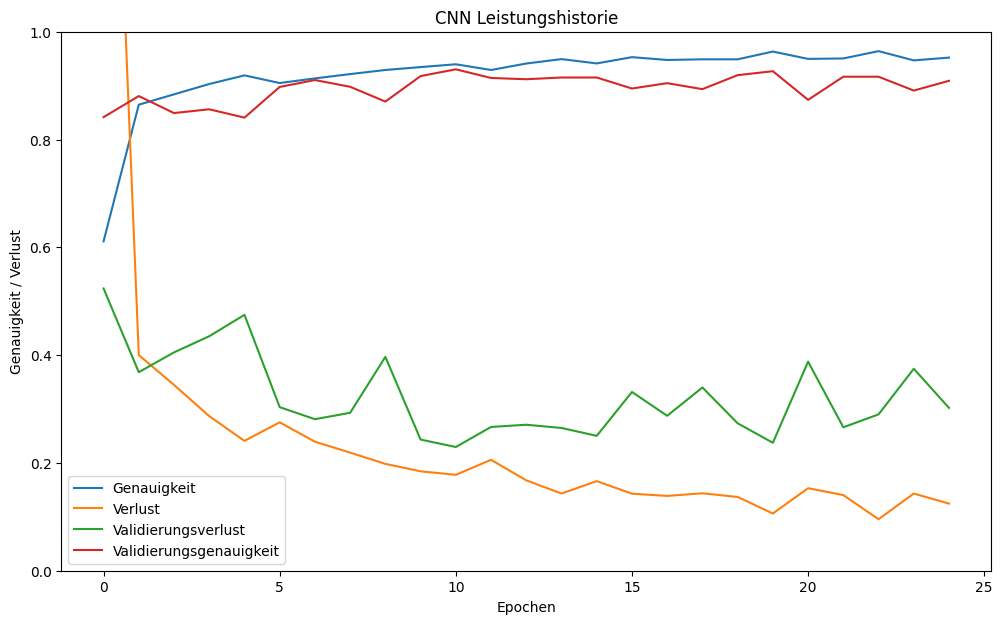

69/69 [==============================] - 17s 234ms/step - loss: 0.2374 - accuracy: 0.9267


[0.23739786446094513, 0.9267367124557495]

In [20]:
# Historien 1 & 2 kombinieren
combined_history = {
    'accuracy': history1.history['accuracy'] + history2.history['accuracy'],
    'loss': history1.history['loss'] + history2.history['loss'],
    'val_accuracy': history1.history['val_accuracy'] + history2.history['val_accuracy'],
    'val_loss': history1.history['val_loss'] + history2.history['val_loss'],
}

# Kombinierte Historie plotten
x = range(0, len(combined_history['accuracy']))
plt.figure(figsize=(12, 7))
sns.lineplot(x=x, y=combined_history['accuracy'], label='Genauigkeit')
sns.lineplot(x=x, y=combined_history['loss'], label='Verlust')
sns.lineplot(x=x, y=combined_history['val_loss'], label='Validierungsverlust')
sns.lineplot(x=x, y=combined_history['val_accuracy'], label='Validierungsgenauigkeit')
plt.xlabel('Epochen')
plt.ylabel('Genauigkeit / Verlust')
plt.title('CNN Leistungshistorie')
plt.ylim(0, 1)
plt.show()

# Evaluation auf dem Validierungsdatensatz
model.evaluate(val_ds)

In [21]:
# Modell speichern
model.save("transfer_learning_resnet.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [22]:
# Modell laden
from keras.models import load_model
model_loaded = load_model('transfer_learning_resnet.h5')

# Beispielvorhersage mit ausgewähltem Bild
img = keras.preprocessing.image.load_img("images/archive/bloodcells_dataset/eosinophil/EO_27.jpg", target_size=image_size)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
predict = model_loaded.predict(img_array)
print(predict)

1/1 [==============================] - 1s 799ms/step
[[8.7605240e-06 9.9976856e-01 8.6413763e-08 8.0278209e-05 3.8255601e-07
  1.4449890e-05 1.2745400e-04 1.7216670e-10]]


1/1 [==============================] - 0s 41ms/step


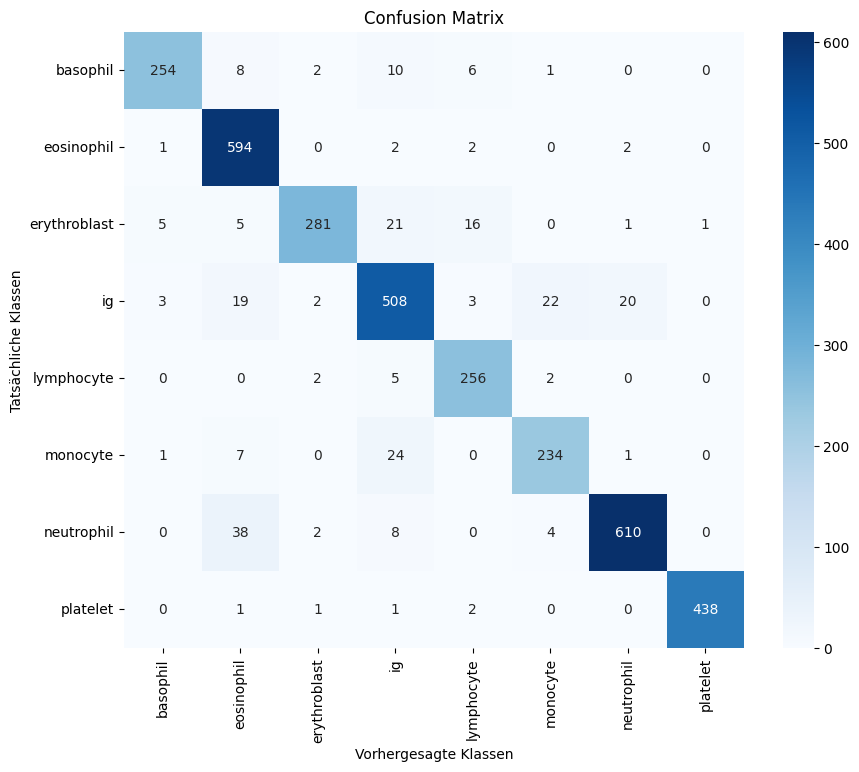

In [26]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Beispiel: Vorhersagen auf dem Validierungsdatensatz
y_true = []  # Die tatsächlichen Klassen
y_pred = []  # Die vorhergesagten Klassen

for images, labels in val_ds:
    y_true.extend(np.argmax(labels, axis=1))  # Erhalte die tatsächlichen Klassen
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))  # Erhalte die vorhergesagten Klassen

# Confusion Matrix erstellen
conf_matrix = confusion_matrix(y_true, y_pred)

# Klassennamen (optional, falls du sie hast)
class_names = ["basophil", "eosinophil", "erythroblast", "ig", "lymphocyte", "monocyte", "neutrophil", "platelet"]

# Confusion Matrix als Heatmap darstellen
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Vorhergesagte Klassen')
plt.ylabel('Tatsächliche Klassen')
plt.title('Confusion Matrix')
plt.show()
